In [205]:
import os
import datetime
from datetime import datetime
from datetime import timedelta
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
import matplotlib.patches as mpatches
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cbook as cbook
import netCDF4
import xarray as xr
import pandas as pd
import glob
from typing import List
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
warnings.simplefilter('ignore')
from pathlib import Path
import seaborn as sns
from numpy.ma import log10
import itertools
from matplotlib.pyplot import subplots, colorbar, cm
import matplotlib.colors as mcolors
from numpy.ma import log10
from matplotlib.dates import date2num, DateFormatter, HourLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [206]:
# This is the folder where the original data is stored
original_data_path = Path("C:\\Users\\harr732\\OneDrive - PNNL\\Documents\\Data") ##EDIT!

# This is the folder where you'll save the new data
hand_labeled_data_path = Path("C:\\Users\\harr732\\OneDrive - PNNL\\Documents\\Data\\data_2")##EDIT!

# This is the folder where you'll save the plots
# plots_path = Path("/home/goldberger/CLDPHS_VAP_Aircraft/Plots/")##EDIT!

In [207]:
year = '2018'##EDIT!
month = '02'##EDIT!

filelist = glob.glob(os.path.join(original_data_path, '*' + year + month + '*.nc'))
filelist.sort()
date_str_list = [filelist[mj][len(filelist[mj])-18:len(filelist[mj])-10] for mj in range(len(filelist))]
print(date_str_list)

['20180201', '20180202', '20180203', '20180204', '20180205', '20180206', '20180207', '20180208', '20180209', '20180210', '20180211', '20180212', '20180213', '20180214', '20180215', '20180216', '20180217', '20180218', '20180219', '20180220', '20180221', '20180222', '20180223', '20180224', '20180225', '20180226', '20180227', '20180228']


In [208]:
# This function loads in a single file

def getCLOUDVAP(date_input, date_str_list, filelist): # "YYYYMMDD"

    # Get Day
    try: 
        date_index = date_str_list.index(date_input)
    except ValueError:
        print('Check if date_input as a string in format YYYYMMDD.')
        print('Try a date between ' + date_str_list[0] + ' - ' + date_str_list[-1])

    # Get Data
    with xr.open_dataset(filelist[date_index]) as ds:
        ds
    time = ds['time'].data
    height = ds['height'].data
    cldphase_mplgr = ds['cloud_phase_mplgr'].data
    cldphase_layer_mplgr = ds['cloud_phase_layer_mplgr'].data
    mpl_dep = ds['mpl_linear_depol_ratio'].data
    mpl_backscat = ds['mpl_backscatter'].data * \
        (ds['height'].data**2)
    mpl_backscat[mpl_backscat <= 0] = 10**-9
    ds['mpl_backscatter'].data = mpl_backscat
    ds['mpl_backscatter'].attrs[
        'units'] = f"log10({ds['mpl_backscatter'].attrs['units']})"

    arscl_cloud_top = ds['cloud_layer_top_height'].data
    arscl_cloud_base = ds['cloud_layer_base_height'].data
    arscl_ze = ds['reflectivity_best_estimate'].data
    arscl_ze_snr = ds['radar_signal_to_noise_ratio'].data
    arscl_w = ds['spectral_width'].data
    arscl_mdv = ds['mean_doppler_velocity'].data
    combined_ze = arscl_ze.copy()
    combined_mdv = arscl_mdv.copy()
    combined_w = arscl_w.copy()
    mwr_lwp = ds['mwrret1liljclou_be_lwp'].data
    sonde_temp = ds['temp'].data

    mpl_backscat_ts = log10(mpl_backscat).transpose()

    cldphase_layer_pixel = np.zeros(mpl_backscat.shape, dtype=int)
    for j, k in itertools.product(range(0, len(time)), range(0, 10)):
        cloud_top_jk = arscl_cloud_top[j, k] * 0.001
        cloud_base_jk = arscl_cloud_base[j, k] * 0.001
        if(cloud_top_jk > 0) and (cloud_base_jk > 0):
            if(cldphase_layer_mplgr[j, k] == 1):
                cldphase_layer_pixel[j, np.where(
                    (height <= cloud_top_jk) & (height >= cloud_base_jk))] = 1
            if(cldphase_layer_mplgr[j, k] == 2):
                cldphase_layer_pixel[j, np.where(
                    (height <= cloud_top_jk) & (height >= cloud_base_jk))] = 2
            if(cldphase_layer_mplgr[j, k] == 3):
                cldphase_layer_pixel[j, np.where(
                    (height <= cloud_top_jk) & (height >= cloud_base_jk))] = 3

    return {"time": time, "height": height, "cldphase_mplgr": cldphase_mplgr,"cldphase_layer_mplgr": cldphase_layer_mplgr, "mpl_dep": mpl_dep, "mpl_backscat": mpl_backscat,"arscl_cloud_top": arscl_cloud_top, "arscl_cloud_base": arscl_cloud_base, "arscl_ze": arscl_ze, "arscl_ze_snr": arscl_ze_snr, "arscl_w": arscl_w, "arscl_mdv": arscl_mdv,"combined_ze": combined_ze, "combined_mdv": combined_mdv, "combined_w": combined_w,"mwr_lwp": mwr_lwp, "sonde_temp": sonde_temp, "mpl_backscat_ts": mpl_backscat_ts,"cldphase_layer_pixel": cldphase_layer_pixel}
# How to use:
# d = getCLOUDVAP('YYYYMMDD', date_str_list, filelist)
# time = d["time"]

In [209]:
# This function makes plots pretty :)

def set_axes(ax, font_size, font_weight, up_hgt, x_nvis,color_bar_label, padding):
    ax.set_xlabel(ax.get_xlabel(), fontsize=font_size, fontweight=font_weight)
    ax.set_ylabel(ax.get_ylabel(), fontsize=font_size, fontweight=font_weight)
    ax.set_title(ax.get_title(), fontsize=font_size, fontweight=font_weight)
    
    for tick in ax.get_xticklabels():
        tick.set_fontsize(font_size)
    
    for tick in ax.get_yticklabels():
        tick.set_fontsize(font_size)
        
    clrs = sns.color_palette("colorblind", 9)
    font = {'weight': font_weight, 'size': font_size}
    matplotlib.rc('font', **font)
    
    ax.set_ylim(0, up_hgt)
    plt.locator_params(axis='y', nbins=5)
    ax.set_ylabel('Height (km)')
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", "3%", pad=padding)
    cb = colorbar(pplot, cax=cax)
    cb.ax.set_ylabel((color_bar_label))
    cb.ax.set_ylabel(cb.ax.get_ylabel(), fontsize=font_size, fontweight=font_weight)
    
    if x_nvis ==1:
        plt.setp(ax.get_xticklabels(), visible=False)
        
    return cb, ax
# # Example usage:
# fig, ax = plt.subplots()
# ax.plot([1, 2, 3, 4], [2, 4, 1, 3])

# # Call the function to set the font size for the axes
# set_axes(ax, 12, 'bold', 8, 1)

# plt.show()

In [210]:
day = '14' ##EDIT!
date_input = year + month + day
print('This is the specific day: ' + date_input)

d = getCLOUDVAP(date_input, date_str_list, filelist)

This is the specific day: 20180214


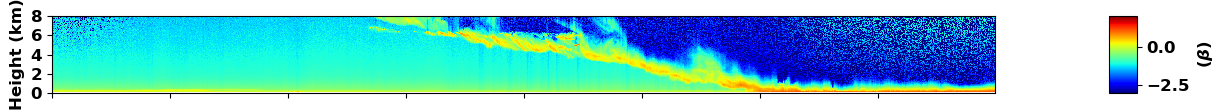

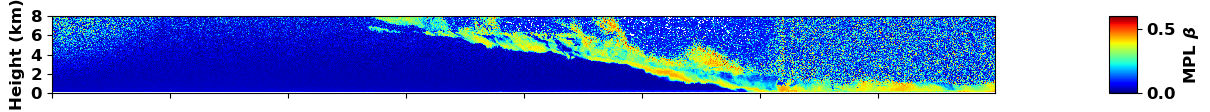

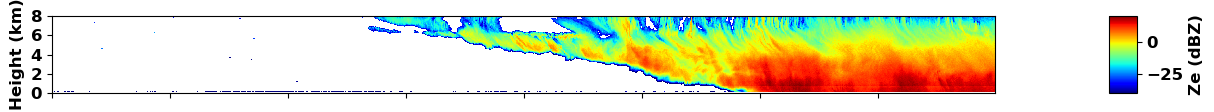

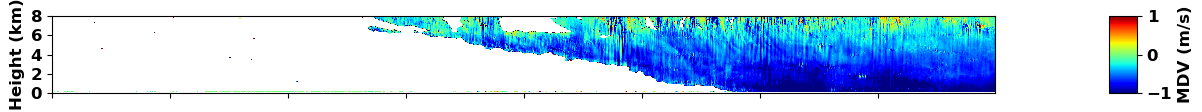

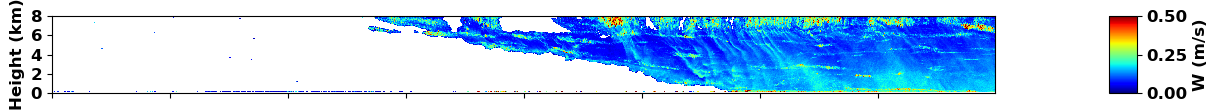

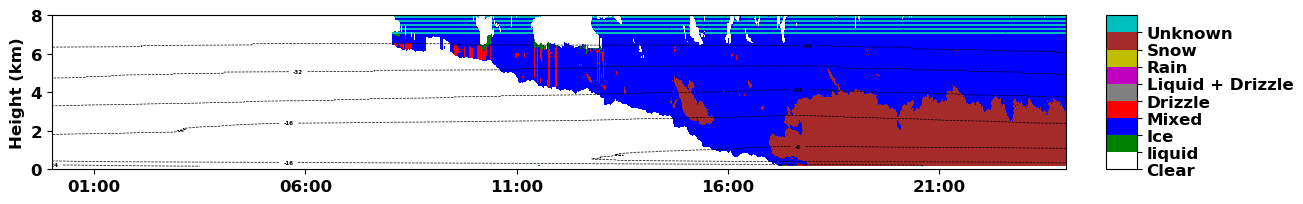

In [211]:
# Plot Radar and MPL Data
color_map = cm.get_cmap("jet")
# mpl backscatter
fig, (ax) = plt.subplots(1,1,figsize=(14,1), sharex=True, sharey=True)
pplot = ax.pcolormesh(d['time'], d['height'], d['mpl_backscat_ts'], vmin=-3, vmax=2, cmap=color_map, shading='auto')
set_axes(ax, 12, 'bold', 8, 1, r'($\beta$)',"12%")
# mpl_linear_depol_ratio
fig, (ax1) = plt.subplots(1,1,figsize=(14,1), sharex=True, sharey=True)
pplot = ax1.pcolormesh(d['time'], d['height'], d['mpl_dep'].transpose(),vmin=0, vmax=0.6, cmap=color_map, shading='auto')
set_axes(ax1, 12, 'bold', 8, 1,r'MPL $\beta$',"12%")
# radar Ze
fig, (ax2) = plt.subplots(1,1,figsize=(14,1), sharex=True, sharey=True)
pplot = ax2.pcolormesh(d['time'], d['height'], d['combined_ze'].transpose(),vmin=-40, vmax=20, cmap=color_map, shading='auto')
set_axes(ax2, 12, 'bold', 8, 1,'Ze (dBZ)',"12%")
# plot radar Doppler velocity
fig, (ax3) = plt.subplots(1,1,figsize=(14,1), sharex=True, sharey=True)
pplot = ax3.pcolormesh(d['time'], d['height'], d['combined_mdv'].transpose(),vmin=-1, vmax=1, cmap=color_map, shading='auto')
set_axes(ax3, 12, 'bold', 8, 1,'MDV (m/s)',"12%")
# plot radar Doppler spectra width
fig, (ax4) = plt.subplots(1,1,figsize=(14,1), sharex=True, sharey=True)
pplot = ax4.pcolormesh(d['time'], d['height'], d['combined_w'].transpose(),vmin=0, vmax=0.5, cmap=color_map, shading='auto')
set_axes(ax4, 12, 'bold', 8, 1,'W (m/s)',"12%")

################################

# Plot cloud phase datasets from ground

fig, (ax) = plt.subplots(1,1,figsize=(14,2), sharex=True, sharey=True)

# plot cldphase_pixel
cmap = ListedColormap(['w', 'g', 'b', 'r','gray','m','y','brown','c'])
pplot = ax.contour(d['time'], d['height'], d['sonde_temp'].transpose(),vmin=-40, vmax=40, levels = 9, colors = 'black', linestyles = '--',linewidths = 0.5)
ax.clabel(pplot,fontsize = 4,inline = True,fmt='%1.0f')
pplot = ax.pcolormesh(d['time'], d['height'], d['cldphase_mplgr'].transpose(),vmin=0, vmax=9, cmap=cmap, shading='auto')

cb, ax = set_axes(ax, 12, 'bold', 8, 0,'',"4%")

cb.ax.locator_params(nbins=8)
#cb.set_ticks([0.33, 1.33, 2.33, 3.33, 4.33, 5.33, 6.33, 7.33, 8.33])
cb.set_ticks([0, 1, 2, 3, 4, 5, 6, 7, 8])
cb.set_ticklabels(['Clear', 'liquid', 'Ice', 'Mixed','Drizzle','Liquid + Drizzle','Rain','Snow','Unknown'])

date_fmt = DateFormatter('%H:00')
hour_loc = HourLocator(interval=5)
ax.xaxis.set_major_formatter(date_fmt)
ax.xaxis.set_major_locator(hour_loc)


In [212]:
# Open in xarray format for easier indexing

date_index = date_str_list.index(date_input)
with xr.open_dataset(filelist[date_index]) as ds:
        ds

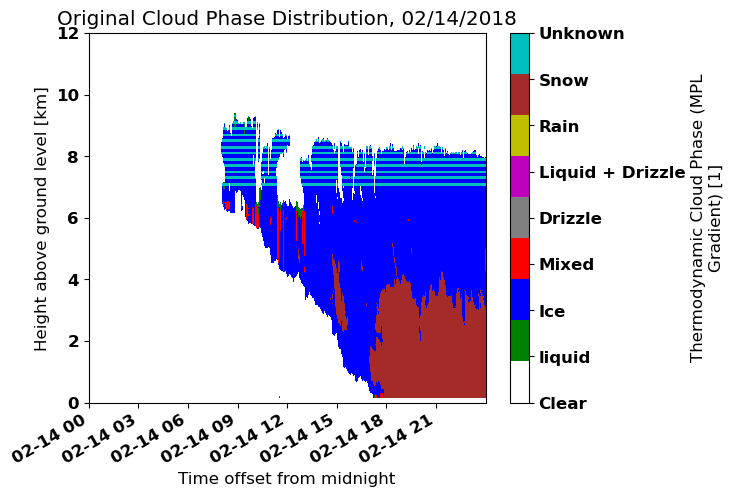

In [213]:
# Plot just the thermocld phase time series

plot = ds['cloud_phase_mplgr'].transpose().plot(cmap = cmap)
# Get the colorbar object from the plot
colorbar = plot.colorbar

# Add a title to the plot
plt.title('Original Cloud Phase Distribution, ' + month + '/' + day + '/' + year)

# Set y-axis limits
plt.ylim(0,12)

# Define new tick labels
new_tick_labels = ['Clear', 'liquid', 'Ice', 'Mixed','Drizzle','Liquid + Drizzle','Rain','Snow','Unknown']

# Set the new tick positions and labels
num_ticks = len(new_tick_labels)
tick_positions = np.linspace(colorbar.vmin, colorbar.vmax, num_ticks)
colorbar.set_ticks(tick_positions)
colorbar.set_ticklabels(new_tick_labels)

In [214]:
# Get selection we want to zoom in on
time_range = slice(pd.to_datetime(year + '-' + month + '-' + day +'T' + '06:00:00'), # manually input start time ##EDIT!
                   pd.to_datetime(year + '-' + month + '-' + day + 'T' + '23:50:00')) # manually input end time ##EDIT!

height_range = slice(1,10) ##EDIT!

ds_zoom = ds.sel(time = time_range, height = height_range)
ds_zoom

<xarray.Dataset>
Dimensions:                            (time: 2141, bound: 2, height: 301,
                                        layer: 10)
Coordinates:
  * time                               (time) datetime64[ns] 2018-02-14T06:00...
  * height                             (height) float32 1.0 1.03 ... 9.97 10.0
  * layer                              (layer) int32 0 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: bound
Data variables: (12/47)
    base_time                          datetime64[ns] ...
    time_offset                        (time) datetime64[ns] ...
    time_bounds                        (time, bound) datetime64[ns] ...
    cloud_flag                         (time, height) float64 ...
    cloud_phase_hsrl                   (time, height) float64 ...
    qc_cloud_phase_hsrl                (time, height) int32 ...
    ...                                 ...
    mwrret1liljclou_be_pwv             (time) float32 ...
    mwrret1liljclou_tbsky23            (time) float32 ...
    mwrret1liljclou_tbsky31            (time) float32 ...
    lat                                float32 ...
    lon                                float32 ...
    alt                                float32 ...
Attributes: (12/57)
    command_line:                                      thermocldphase -s nsa ...
    Conventions:                                       ARM-1.3
    process_version:                                   vap-thermocldphase-0.3...
    dod_version:                                       thermocldphase-c1-1.3
    input_datastreams:                                 nsa30smplcmask1zwangC1...
    site_id:                                           nsa
    ...                                                ...
    hsrl_weak_backscatter_threshold_comment:           Backscatter threshold ...
    top_backscatter_grad_threshold:                    10.0
    top_backscatter_grad_threshold_comment:            Threshold of backscatt...
    base_backscatter_grad_threshold:                   1.0
    base_backscatter_grad_threshold_comment:           Threshold of backscatt...
    history:                                           created by user levin ...

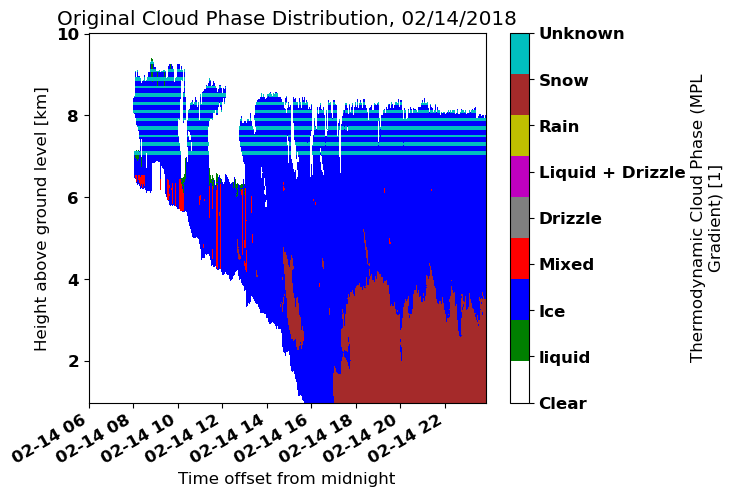

In [215]:
# Plot zoomed in section, here were going to make it a function for easier future plotting

def quicklook(dataset):
    plot = dataset['cloud_phase_mplgr'].transpose().plot(cmap = cmap)
    # Get the colorbar object from the plot
    colorbar = plot.colorbar

    # Add a title to the plot
    plt.title('Original Cloud Phase Distribution, ' + month + '/' + day + '/' + year)

    # Define new tick labels
    new_tick_labels = ['Clear', 'liquid', 'Ice', 'Mixed','Drizzle','Liquid + Drizzle','Rain','Snow','Unknown']

    # Set the new tick positions and labels
    num_ticks = len(new_tick_labels)
    tick_positions = np.linspace(colorbar.vmin, colorbar.vmax, num_ticks)
    colorbar.set_ticks(tick_positions)
    colorbar.set_ticklabels(new_tick_labels)
    return

# Try it out
quicklook(ds_zoom)

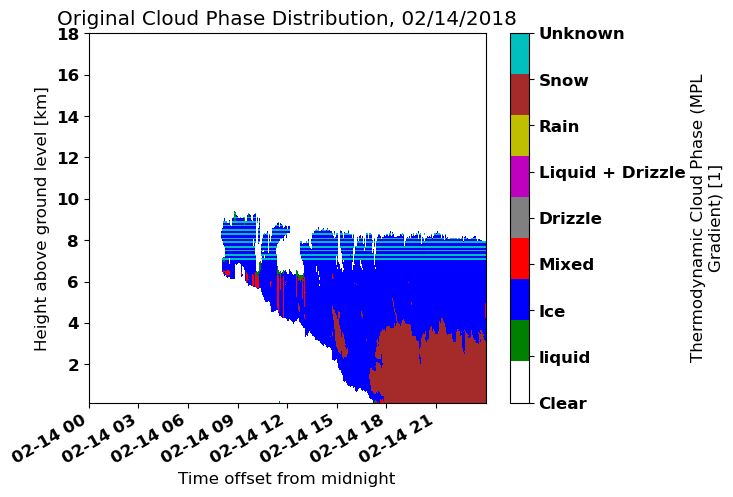

In [216]:
plot = ds['cloud_phase_mplgr'].transpose().plot(cmap = cmap)
# Get the colorbar object from the plot
colorbar = plot.colorbar

# Add a title to the plot
plt.title('Original Cloud Phase Distribution, ' + month + '/' + day + '/' + year)

# Define new tick labels
new_tick_labels = ['Clear', 'liquid', 'Ice', 'Mixed','Drizzle','Liquid + Drizzle','Rain','Snow','Unknown']

# Set the new tick positions and labels
num_ticks = len(new_tick_labels)
tick_positions = np.linspace(colorbar.vmin, colorbar.vmax, num_ticks)
colorbar.set_ticks(tick_positions)
colorbar.set_ticklabels(new_tick_labels)

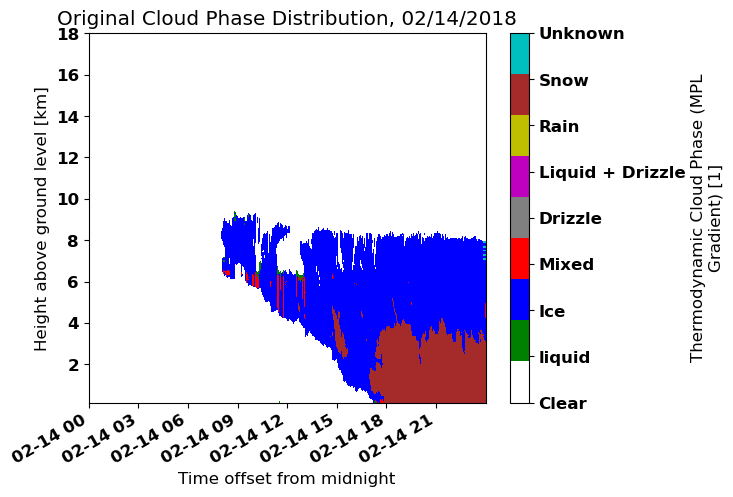

In [217]:
# Apply the `where` condition to the selected range
subset = ds['cloud_phase_mplgr'].sel(time=time_range, height=height_range)
modified_subset = subset.where(subset != 8, 2) ##EDIT! 8=unknown, 2=ice 


# # Update the original dataset
ds['cloud_phase_mplgr'].loc[{'time': time_range, 'height': height_range}] = modified_subset

modified_subset
# # Lets plot and check using the quick plot function we wrote
quicklook(ds)

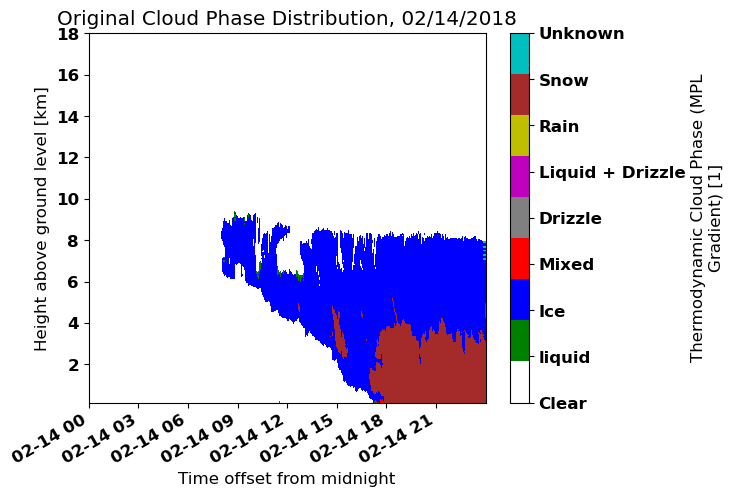

In [218]:
# Apply the `where` condition to the selected range
subset = ds['cloud_phase_mplgr'].sel(time=time_range, height=height_range)
modified_subset = subset.where(subset != 3, 2) ##EDIT! 8=unknown, 2=ice 


# # Update the original dataset
ds['cloud_phase_mplgr'].loc[{'time': time_range, 'height': height_range}] = modified_subset

modified_subset
# # Lets plot and check using the quick plot function we wrote
quicklook(ds)

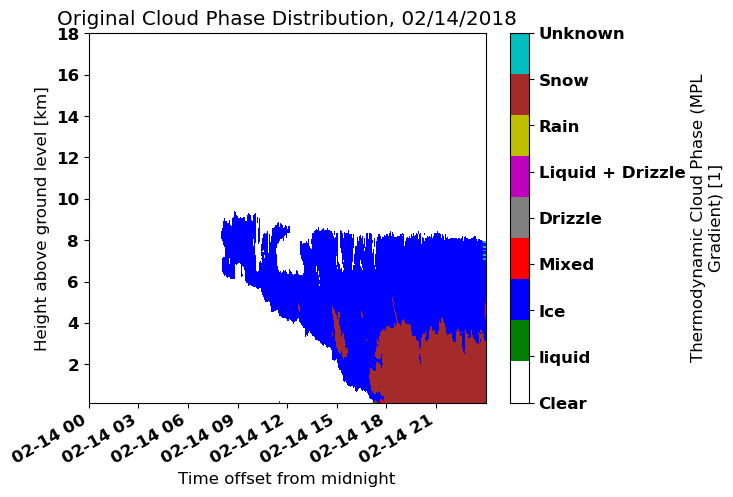

In [219]:
# Apply the `where` condition to the selected range
subset = ds['cloud_phase_mplgr'].sel(time=time_range, height=height_range)
modified_subset = subset.where(subset != 1, 2) ##EDIT! 8=unknown, 2=ice 


# # Update the original dataset
ds['cloud_phase_mplgr'].loc[{'time': time_range, 'height': height_range}] = modified_subset

modified_subset
# # Lets plot and check using the quick plot function we wrote
quicklook(ds)

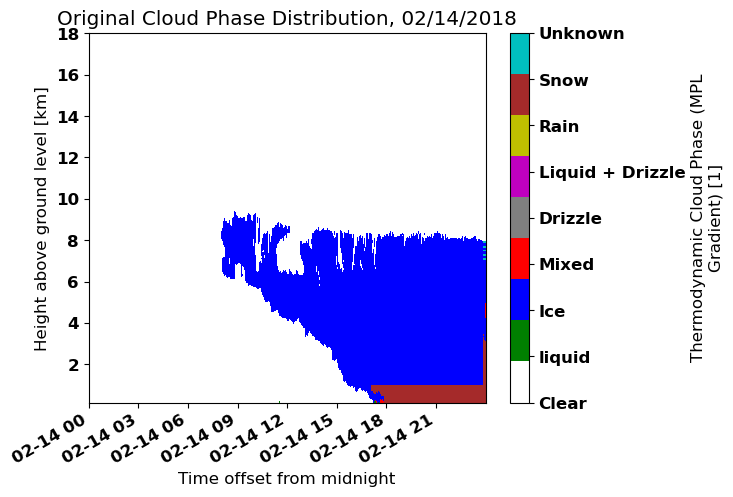

In [253]:
# Apply the `where` condition to the selected range
subset = ds['cloud_phase_mplgr'].sel(time=time_range, height=height_range)
modified_subset = subset.where(subset != 8, 2) ##EDIT! 8=unknown, 2=ice 


# # Update the original dataset
ds['cloud_phase_mplgr'].loc[{'time': time_range, 'height': height_range}] = modified_subset

modified_subset
# # Lets plot and check using the quick plot function we wrote
quicklook(ds)

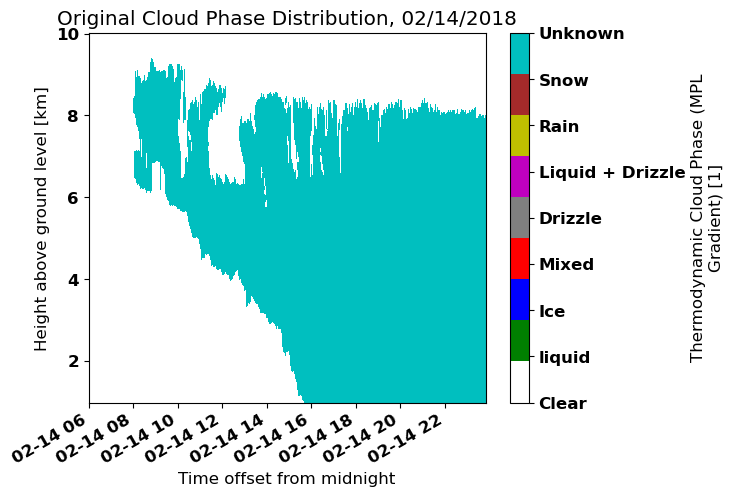

In [255]:
quicklook(ds.sel(time = time_range, height = height_range))